# Задание
Модель: Ridge Regression [Ridge](https://scikit-learn.org/0.21/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

Параметры: bedrooms, waterfront, sqft_living

# Подготовка выборки
Загрузим и изучим выборку. Как мы видим ниже, примерно 10% вариантов значений цен имеют только один объект недвижимости, а дальнейшее изучение выборки дает понимание, что такие аномалии являются либо ошибками ввода (например, значения вроде 460.001 вместо 460.000), либо чрезмерной погрешностью оценки (например, 332.220 долларов).

In [173]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("kc_house_data.csv")

y = data["price"]
X = data[["bedrooms", "waterfront", "sqft_living"]]

total = 0
ones = []
for c, v in y.value_counts().items():
    if v == 1:
        ones.append(c)
    total += v
print(total, len(ones))
print(pd.DataFrame(ones))

21613 2395
              0
0      724000.0
1     2271150.0
2      162950.0
3      919000.0
4      853505.0
...         ...
2390   607010.0
2391  1362500.0
2392   298800.0
2393   957500.0
2394   402101.0

[2395 rows x 1 columns]


Попробуем "спасти" такие значения округлив все цены до десятков тысяч долларов, т.к. меньшая погрешность является маловажной в изучаемом вопросе (рынок жилья в Сиэттле и его окресностях это объекты стоимостью сотни тысяч/миллионы долларов).

In [175]:
import pandas as pd
import numpy as np

data = pd.read_csv("kc_house_data.csv")

y = data["price"].apply(lambda x: int(10000 * round(float(x) / 10000)))
X = data[["bedrooms", "waterfront", "sqft_living"]]

total = 0
ones = []
for c, v in y.value_counts().items():
    if v == 1:
        ones.append(c)
    total += v
print(total, len(ones))
print(pd.DataFrame(ones))

21613 64
          0
0   3340000
1   1630000
2   5350000
3   2240000
4   5300000
..      ...
59  2530000
60  4210000
61  1930000
62  2410000
63  3570000

[64 rows x 1 columns]


Оставшиеся 64 значения мы просто выкинем из датасета как малозначимые выбросы

In [106]:
data = pd.read_csv("kc_house_data.csv")

y = data["price"].apply(lambda x: int(10000 * round(float(x) / 10000)))

total = 0
ones = []
for c, v in y.value_counts().items():
    if v == 1:
        ones.append(c)
    total += v

indieces_to_remove = [k for k, v in y.items() if v in ones]

data = pd.read_csv("kc_house_data.csv")
[data.drop(i, axis=0, inplace=True) for i in indieces_to_remove]
y = data["price"].apply(lambda x: int(10000 * round(float(x) / 10000)))
X = data[["bedrooms", "waterfront", "sqft_living"]]

print(len(y), len(X))

21549 21549


# Разделение выборки на тренировочную и тестовую

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [101]:
print(X_train)

       bedrooms  waterfront  sqft_living  bathrooms
1277          2           0         2630       2.50
395           2           0         1220       1.00
15082         3           0         1330       1.00
19324         3           0         3850       3.00
20060         4           0         2612       2.50
...         ...         ...          ...        ...
11203         4           0         2040       2.50
11611         4           0         2090       2.50
12853         4           0         1880       2.25
1113          4           0         3030       3.25
21415         4           0         2245       2.50

[15084 rows x 4 columns]


# Нормализация данных

In [108]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Обучение модели на тренировочной выборке

In [109]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

# Делаем предсказание используя обученную модель

In [110]:
y_pred = ridge.predict(X_test)
print(y_pred)

[811467.8245701  403906.4179587  772401.77539797 ... 838897.17824416
 409537.84796067 654604.42630879]


# Определяем среднеквадратичную ошибку

In [126]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)


baseline_prediction = np.median(y_train)
baseline_predictions = np.full_like(y_test, fill_value=baseline_prediction)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(baseline_mse, mse, baseline_mse / mse)

118920665119.87625 54524691505.17156 2.181042420177597


# Рисуем гистограмму

Заметим, что тренированая модель дает результат примерно вдвое лучший, чем предсказание с использованием медианных значений аттрибутов

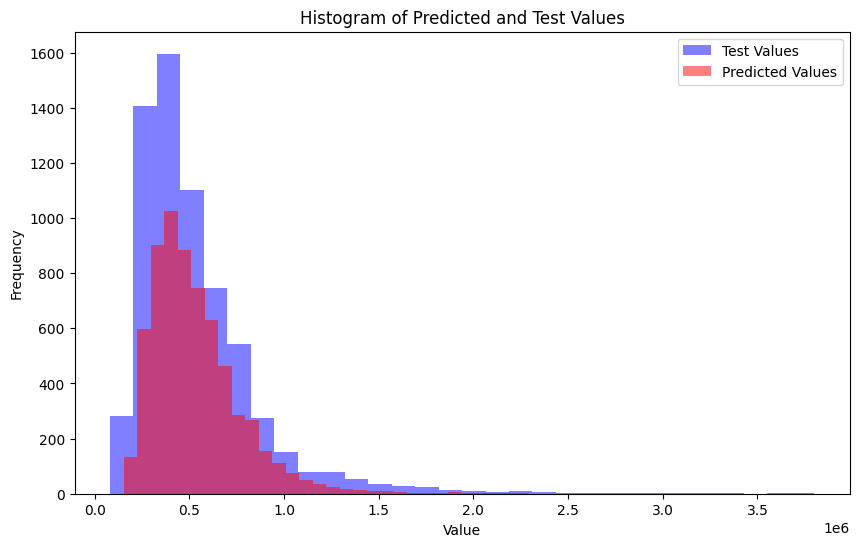

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='Test Values')
plt.hist(y_pred, bins=30, alpha=0.5, color='red', label='Predicted Values')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted and Test Values')
plt.legend()

plt.show()

Из анализа гистограммы мы можем сделать вывод, что алгоритм оценки хоть и дает относительно схожее распределение значений оценки цены, но при этом стабильно переоценивает объекты недвижимости примерно на 50%, что является высокой погрешностью оценки.